# Imports

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers


%matplotlib inline

2023-08-24 15:22:09.866615: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 15:22:09.867932: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 15:22:09.894974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 15:22:09.895514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 15:22:10.378242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Matplotlib settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

# Variables Definitions

In [4]:
path = '/home/faze_vennom/BTP/mitbih_database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepare Input Files

In [5]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [6]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data extraction and preprocessing

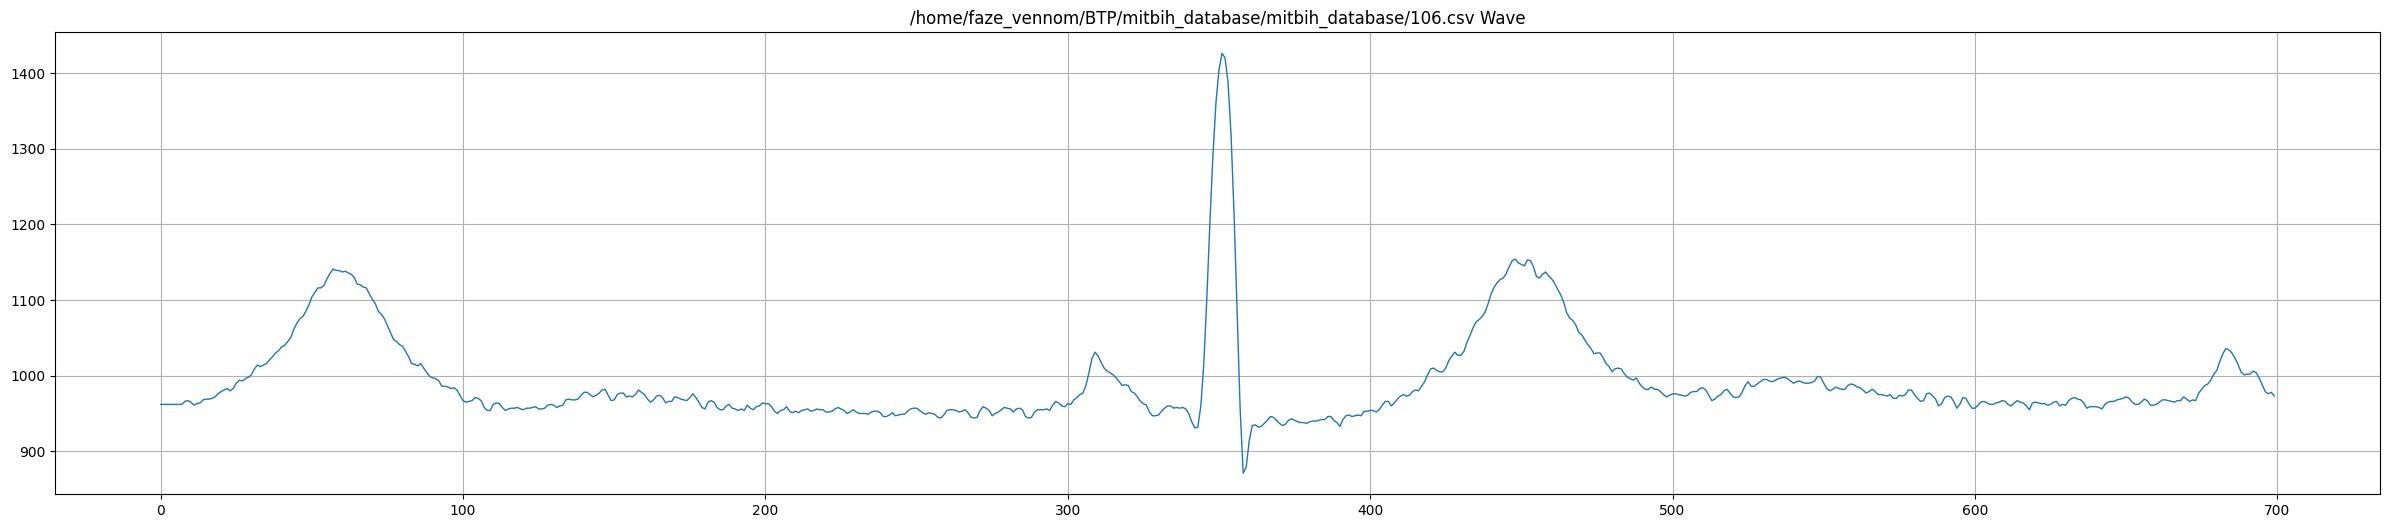

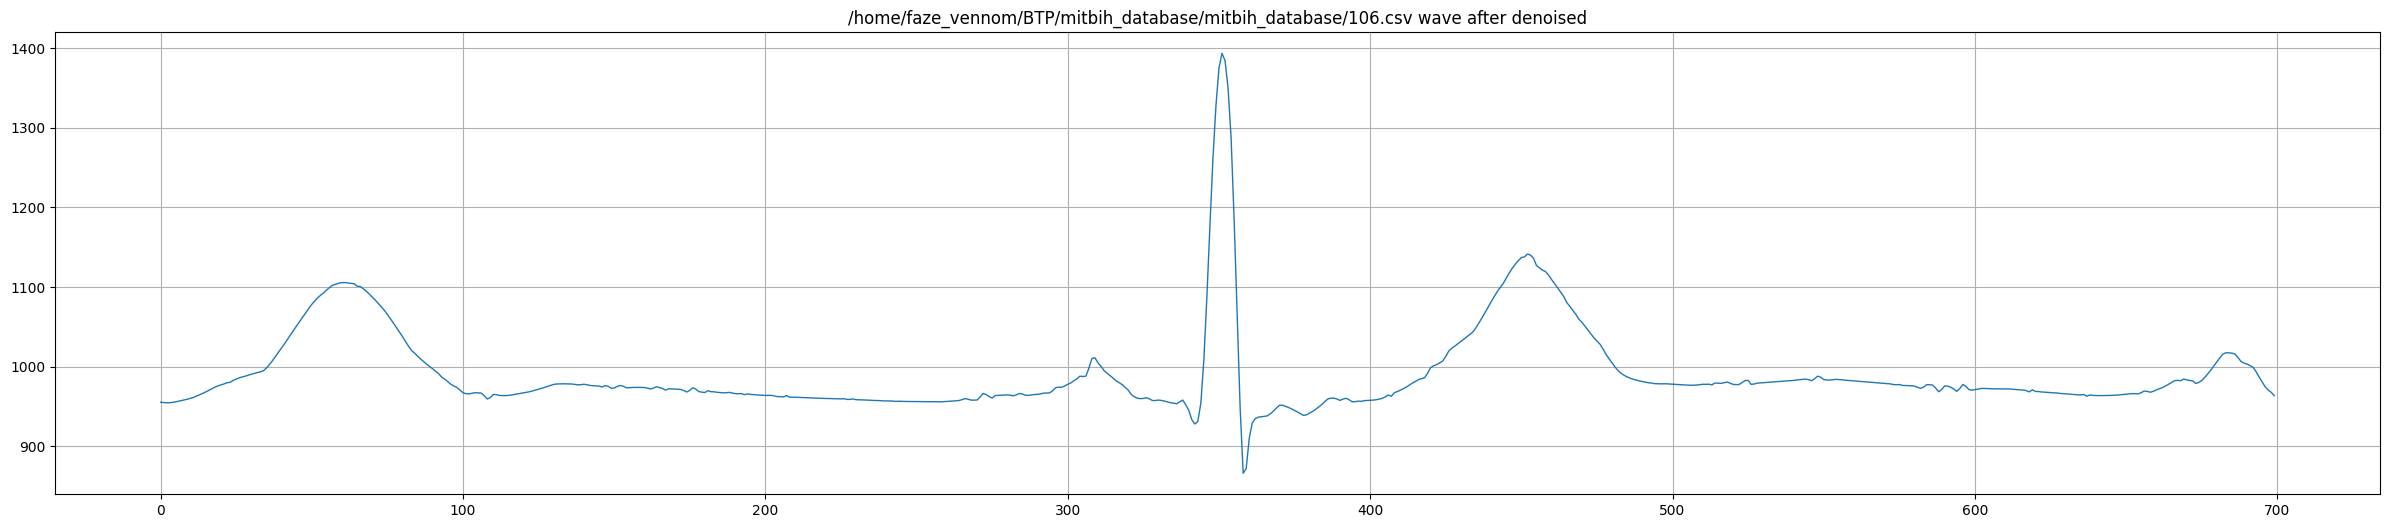

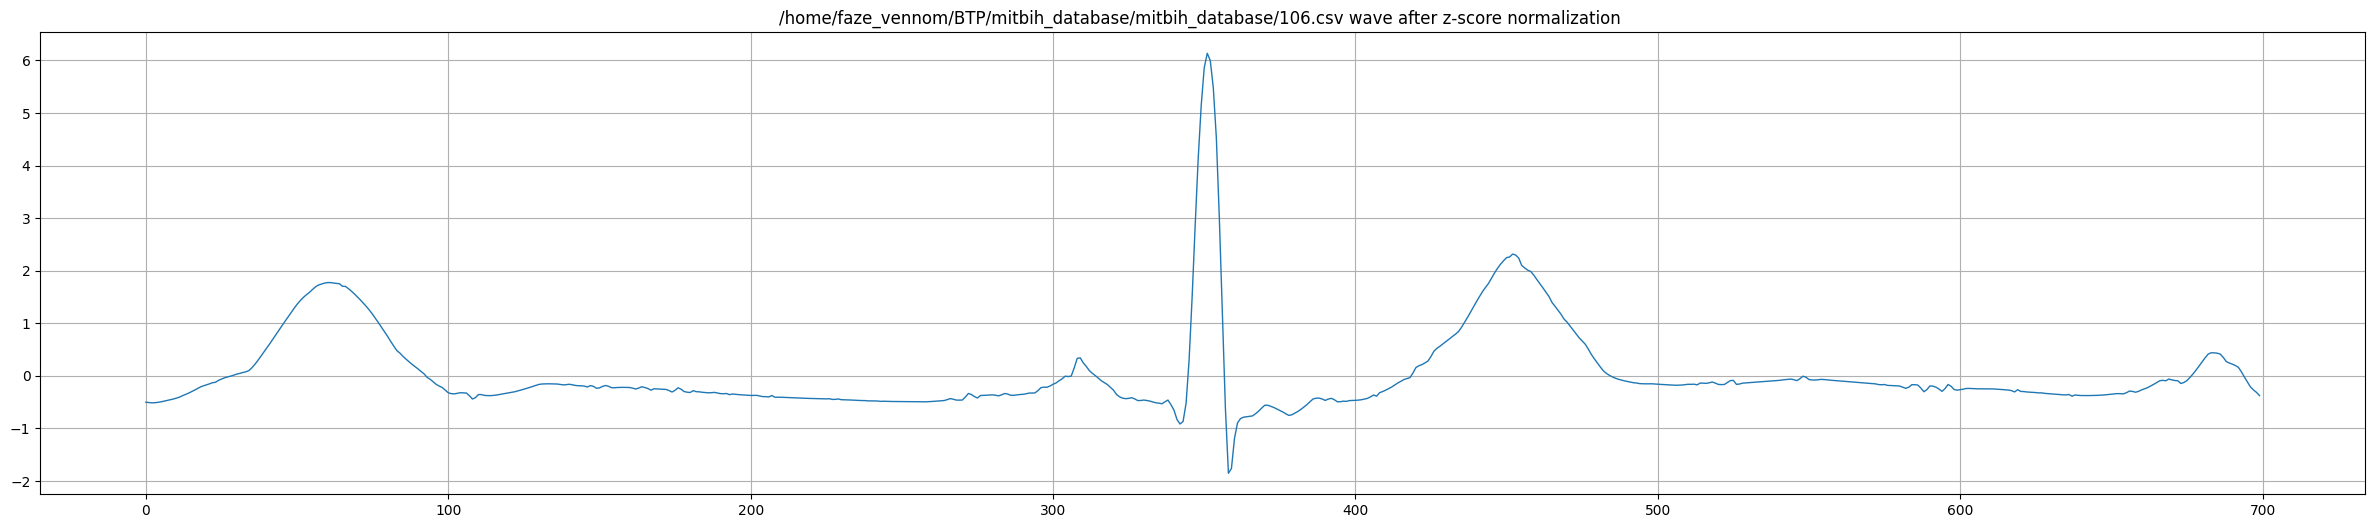

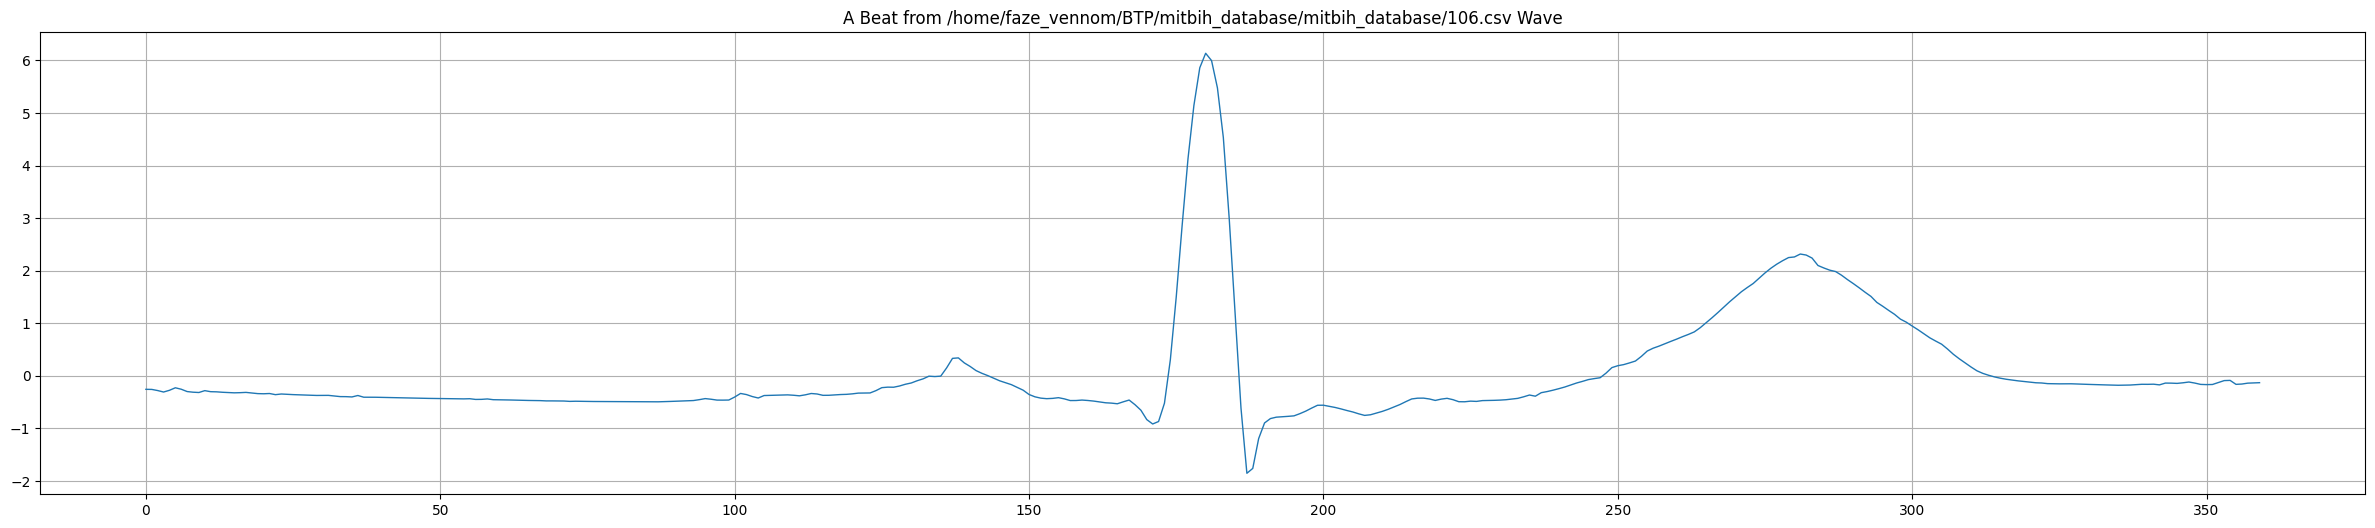

(100012, 360) (100012,)


In [7]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


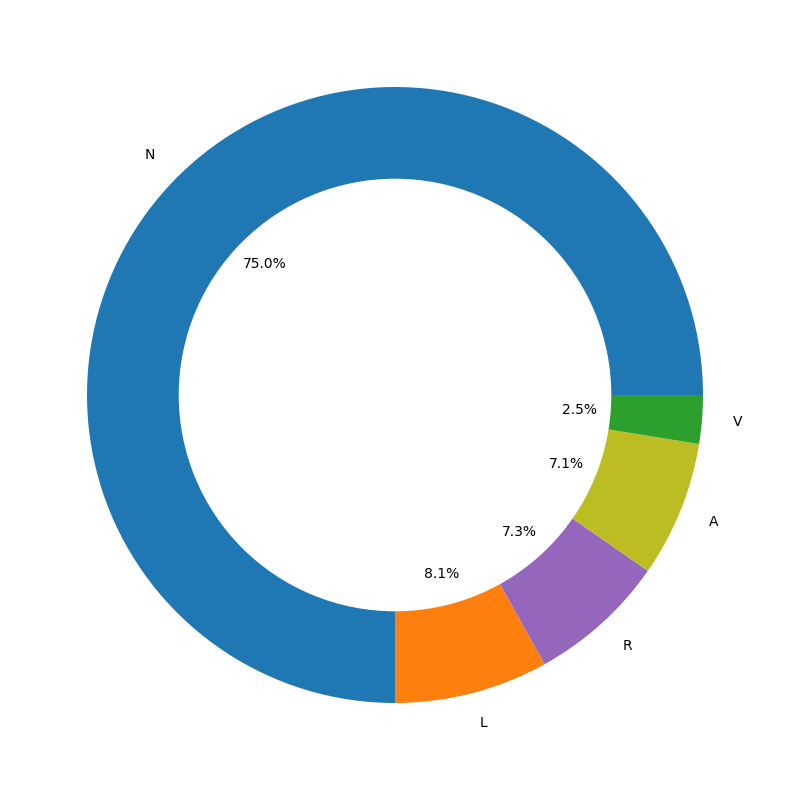

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes
## Addressing Class Imbalance in Micro ECG Classification
Class imbalance in a database of arrhythmia occurs when the number of samples in different arrhythmia types is significantly different. It needs to be addressed because it can lead to biased model training, reduced sensitivity, misleading evaluation metrics.

Various techniques can be used for addressing class imbalance during data preprocessing and model training stages:

Oversampling the Minority Class: This involves creating duplicate samples of the minority class.
Undersampling the Majority Class: In this approach, some samples from the majority class are randomly removed.
Synthetic Data Generation: Using techniques like SMOTE to generate synthetic samples for the minority class.
Cost-Sensitive Learning: Assigning different misclassification costs during model training.
Ensemble Methods: Utilizing ensemble models like AdaBoost or XGBoost.
Performance Metrics: Choosing appropriate evaluation metrics like precision, recall, F1-score, or AUC-ROC.
The choice of rebalancing technique depends on the dataset, model, and specific problem at hand. Careful experimentation is essential.

In [10]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: count, dtype: int64


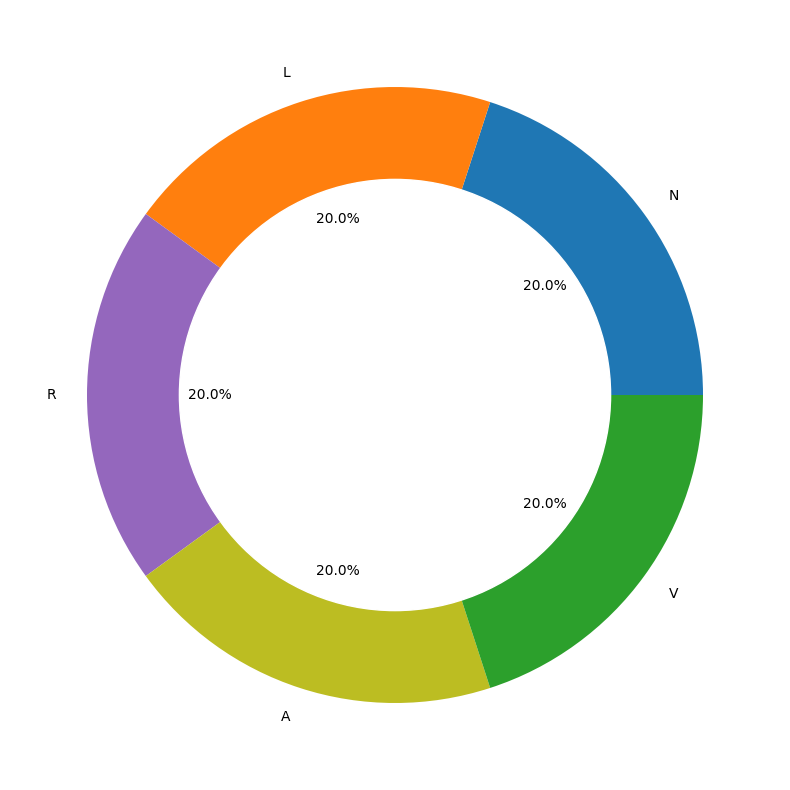

In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train - test Data Spliting
We are keeping 20% data for testing and the rest of the data ffor training

In [12]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [13]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [14]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


# Building the Model Architecture

1. Import necessary libraries and modules.
2. Instantiate an empty Sequential model.
3. Adding 1D convolutional layers (C1, C3, C5, C7) to detect features.
4. Adding average pooling layers (S2, S4, S6, S8) to reduce dimensions.
5. Flattening the data before dense layers.
6. Adding a Dropout layer to prevent overfitting.
7. Adding two dense layers (S10, S11) for classification with L2 regularization.
8. Adding a softmax layer for probability scores.
9. Displaying the model summary.

In [15]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 average_pooling1d (Average  (None, 179, 16)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 average_pooling1d_1 (Avera  (None, 89, 32)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 average_pooling1d_2 (Avera  (None, 44, 64)            0

# Compiling the model

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Fitting the model

In [24]:
history = model.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y))

Epoch 1/100
556/556 [==============================] - 6s 11ms/step - loss: 0.0134 - accuracy: 0.9985 - val_loss: 0.1052 - val_accuracy: 0.9914
Epoch 2/100
556/556 [==============================] - 7s 13ms/step - loss: 0.0101 - accuracy: 0.9994 - val_loss: 0.0849 - val_accuracy: 0.9918
Epoch 3/100
556/556 [==============================] - 8s 14ms/step - loss: 0.0067 - accuracy: 0.9998 - val_loss: 0.0877 - val_accuracy: 0.9904
Epoch 4/100
556/556 [==============================] - 8s 14ms/step - loss: 0.0135 - accuracy: 0.9983 - val_loss: 0.0828 - val_accuracy: 0.9922
Epoch 5/100
556/556 [==============================] - 7s 13ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.0988 - val_accuracy: 0.9928
Epoch 6/100
556/556 [==============================] - 8s 14ms/step - loss: 0.0091 - accuracy: 0.9994 - val_loss: 0.1068 - val_accuracy: 0.9890
Epoch 7/100
556/556 [==============================] - 8s 14ms/step - loss: 0.0090 - accuracy: 0.9992 - val_loss: 0.0814 - val_accuracy:

556/556 [==============================] - 7s 13ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.1220 - val_accuracy: 0.9890
Epoch 58/100
556/556 [==============================] - 7s 13ms/step - loss: 0.0141 - accuracy: 0.9980 - val_loss: 0.0781 - val_accuracy: 0.9910
Epoch 59/100
556/556 [==============================] - 7s 13ms/step - loss: 0.0132 - accuracy: 0.9981 - val_loss: 0.0705 - val_accuracy: 0.9916
Epoch 60/100
556/556 [==============================] - 8s 14ms/step - loss: 0.0107 - accuracy: 0.9992 - val_loss: 0.0766 - val_accuracy: 0.9910
Epoch 61/100
556/556 [==============================] - 7s 13ms/step - loss: 0.0069 - accuracy: 0.9995 - val_loss: 0.0843 - val_accuracy: 0.9904
Epoch 62/100
556/556 [==============================] - 7s 13ms/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 0.0915 - val_accuracy: 0.9900
Epoch 63/100
556/556 [==============================] - 7s 13ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 0.0929 - val_accuracy: 0.991

# Plotting the loss convergence

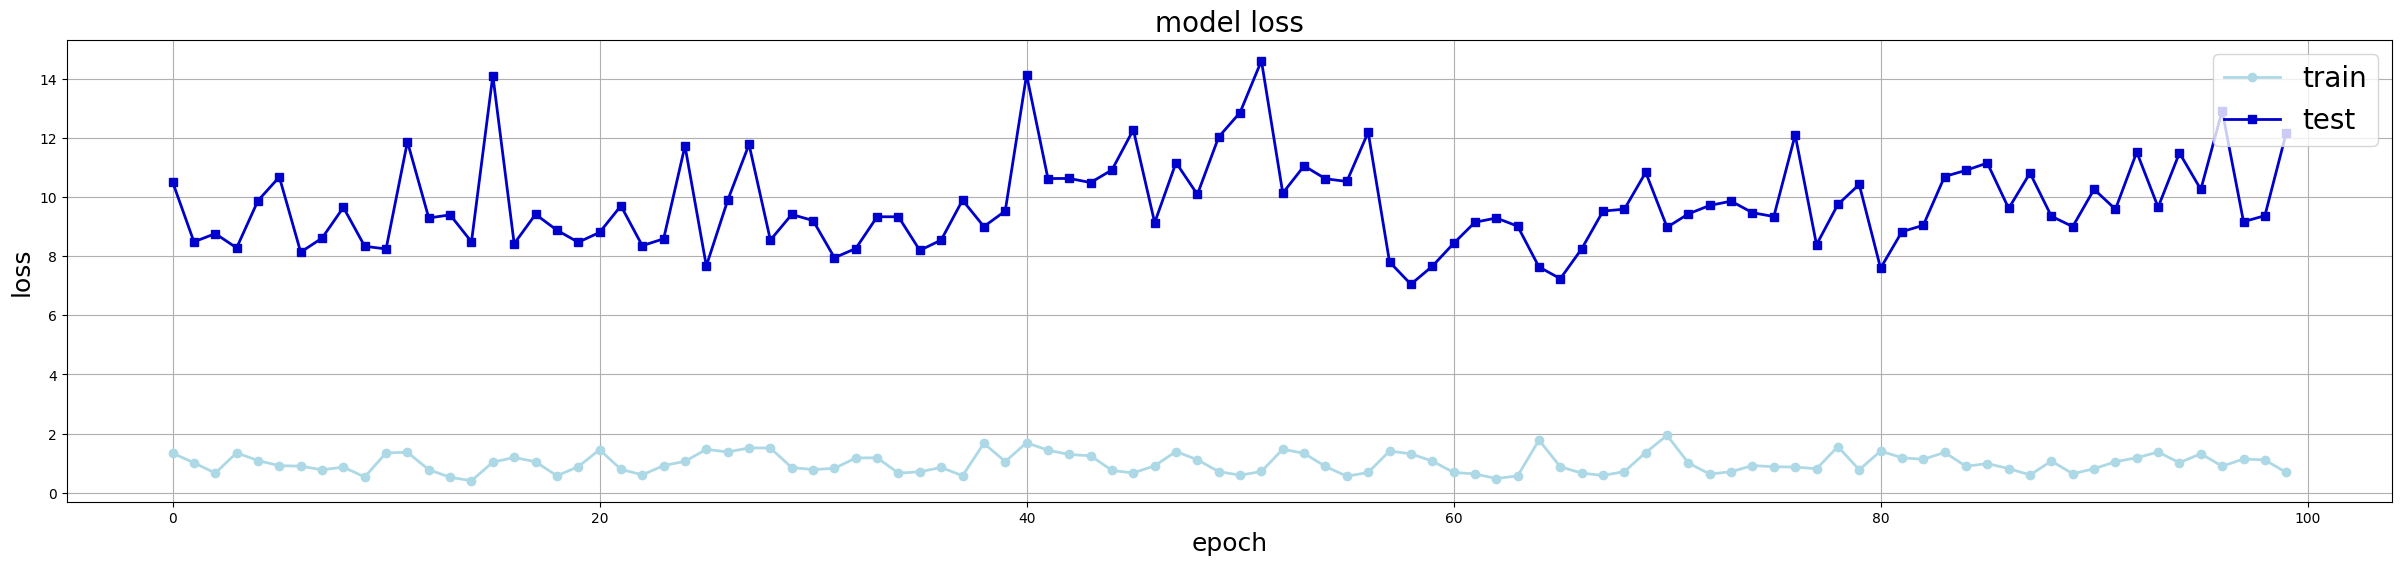

In [28]:
# summarize history for loss 1
loss1 = np.array(history.history['loss']) * 100
val_loss1 = np.array(history.history['val_loss']) * 100

plt.plot(loss1, linewidth=2,marker='o', label='Train Loss', color='#ADD8E6')
plt.plot(val_loss1, linewidth=2,marker='s', label='Validation Loss', color='#0000CD')
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'test'], loc='upper right', fontsize=20)
plt.show()

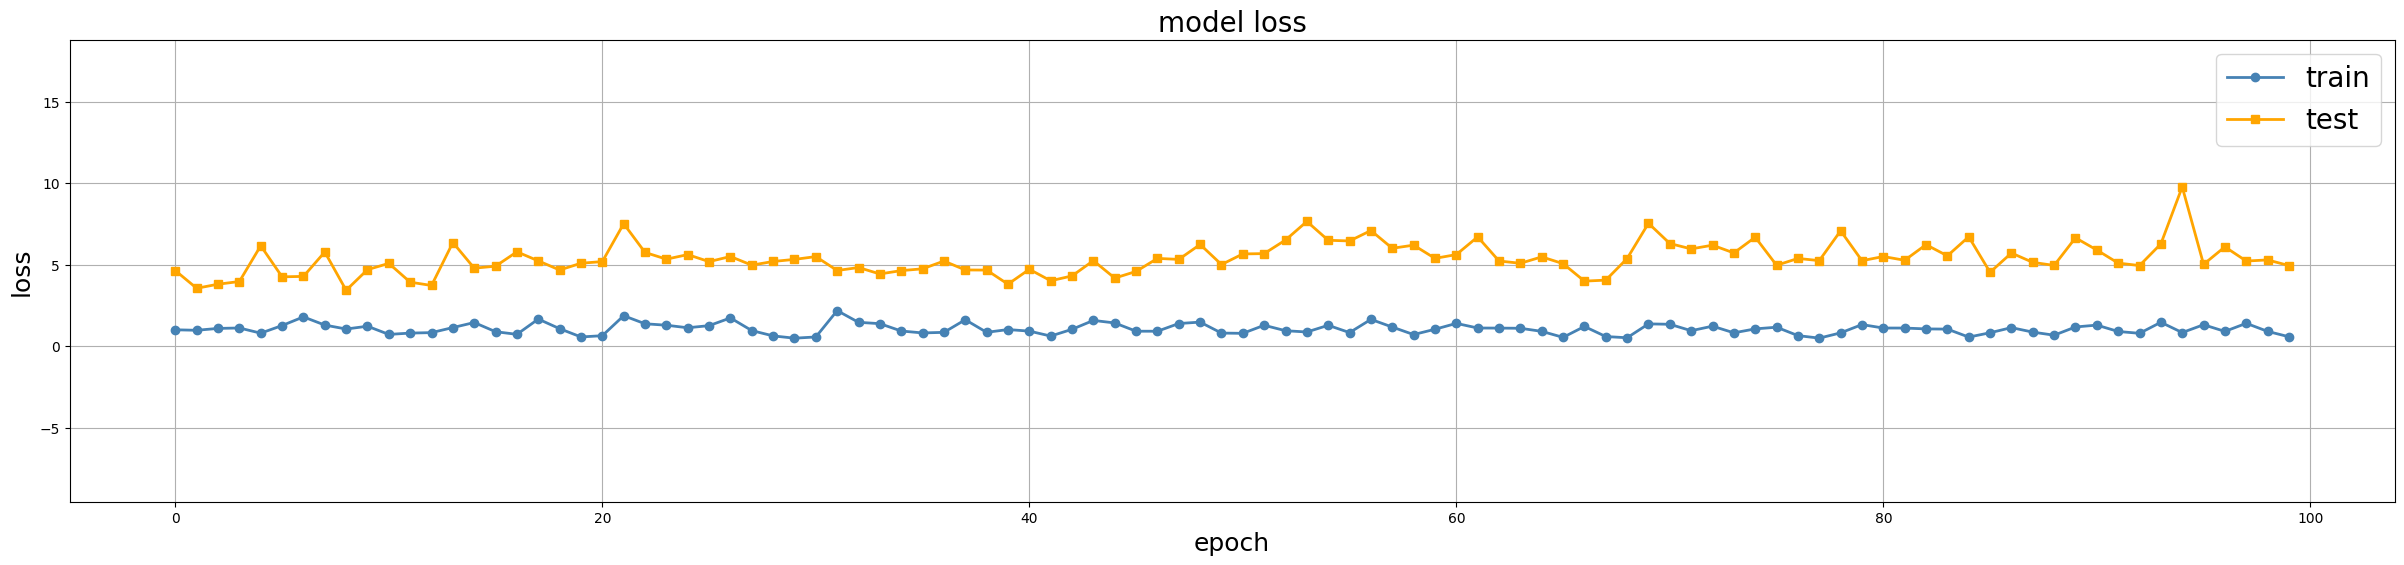

In [55]:
# summarize history for loss 2
loss2 = np.array(history.history['loss']) * 100
val_loss2 = np.array(history.history['val_loss']) * 100

plt.plot(loss2, linewidth=2,marker='o', label='Train Loss', color='#FFA07A')
plt.plot(val_loss2, linewidth=2,marker='s', label='Validation Loss', color='#8B0000')
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.ylim(ymin=loss.min() - 10, ymax=val_loss.max() + 10)
plt.legend(['train', 'test'], loc='upper right', fontsize=20)
plt.show()

NameError: name 'loss' is not defined

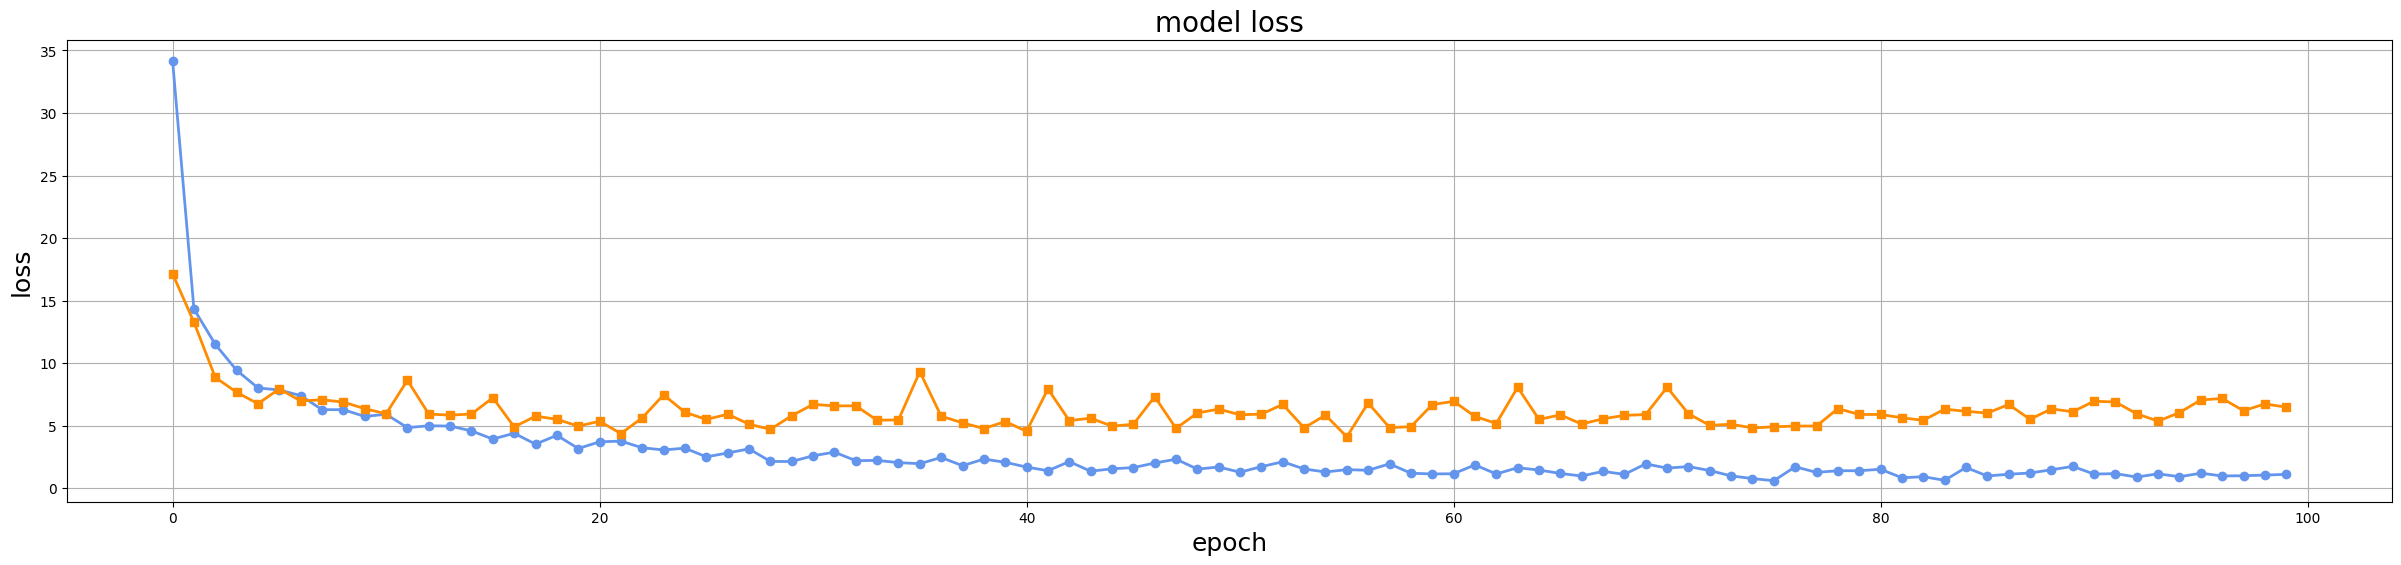

In [18]:
# summarize history for loss 3
loss3 = np.array(history.history['loss']) * 100
val_loss3 = np.array(history.history['val_loss']) * 100

plt.plot(loss3, linewidth=2,marker='o', label='Train Loss', color='#90EE90')
plt.plot(val_loss3, linewidth=2,marker='s', label='Validation Loss', color='#006400')
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.ylim(ymin=loss.min() - 10, ymax=val_loss.max() + 10)
plt.legend(['train', 'test'], loc='upper right', fontsize=20)
plt.show()

NameError: name 'loss' is not defined

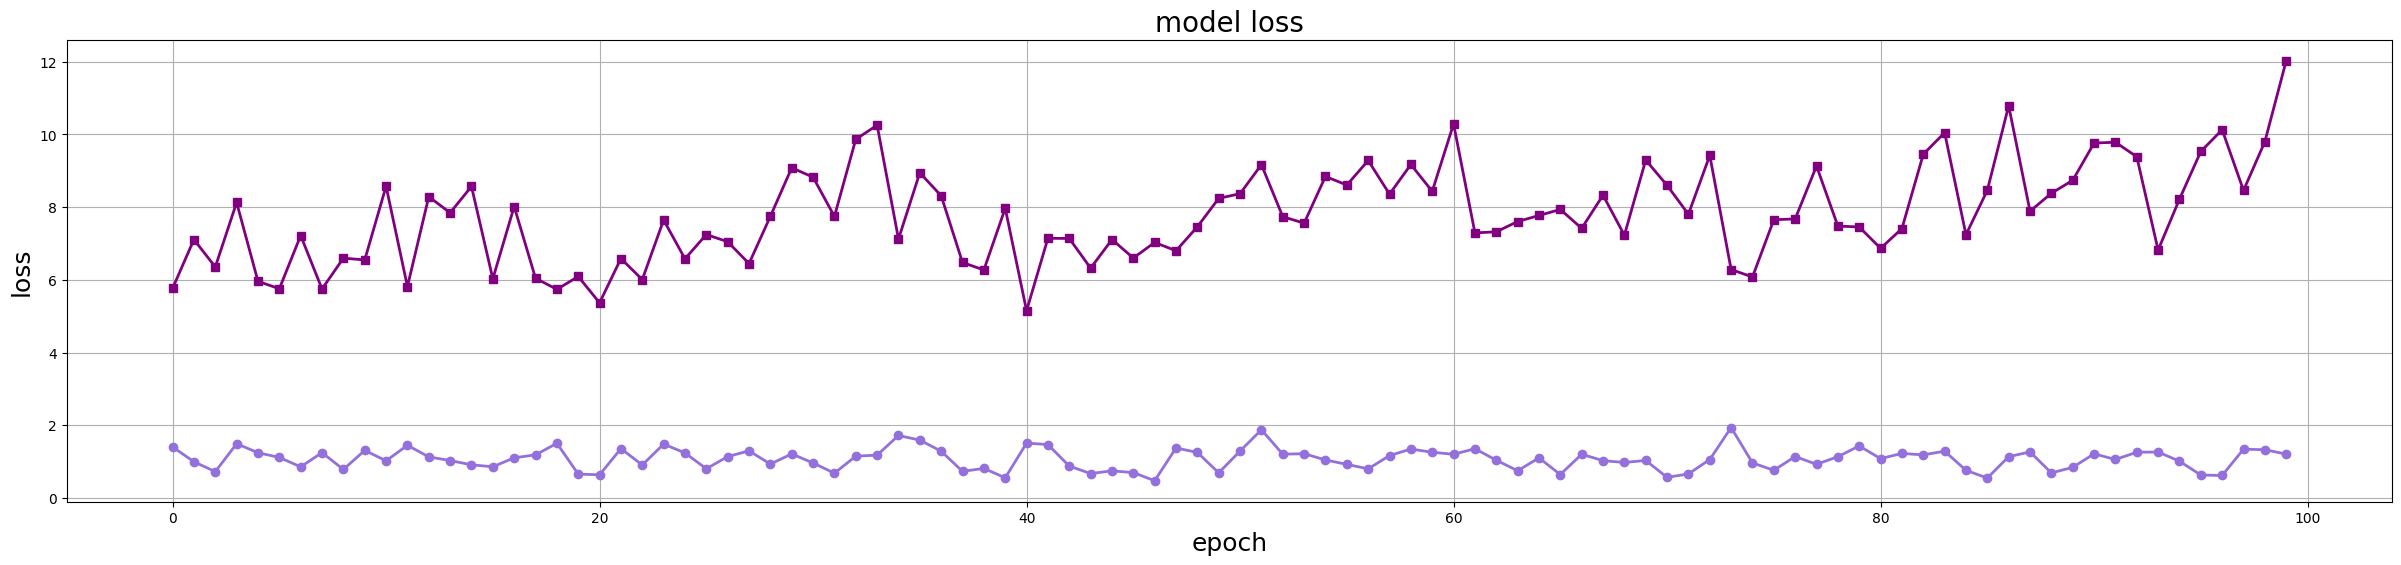

In [22]:
# summarize history for loss 4
loss4 = np.array(history.history['loss']) * 100
val_loss4 = np.array(history.history['val_loss']) * 100

plt.plot(loss4, linewidth=2,marker='o', label='Train Loss', color='#9370DB')
plt.plot(val_loss4, linewidth=2,marker='s', label='Validation Loss', color='#800080')
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.ylim(ymin=loss.min() - 10, ymax=val_loss.max() + 10)
plt.legend(['train', 'test'], loc='upper right', fontsize=20)
plt.show()

NameError: name 'loss' is not defined

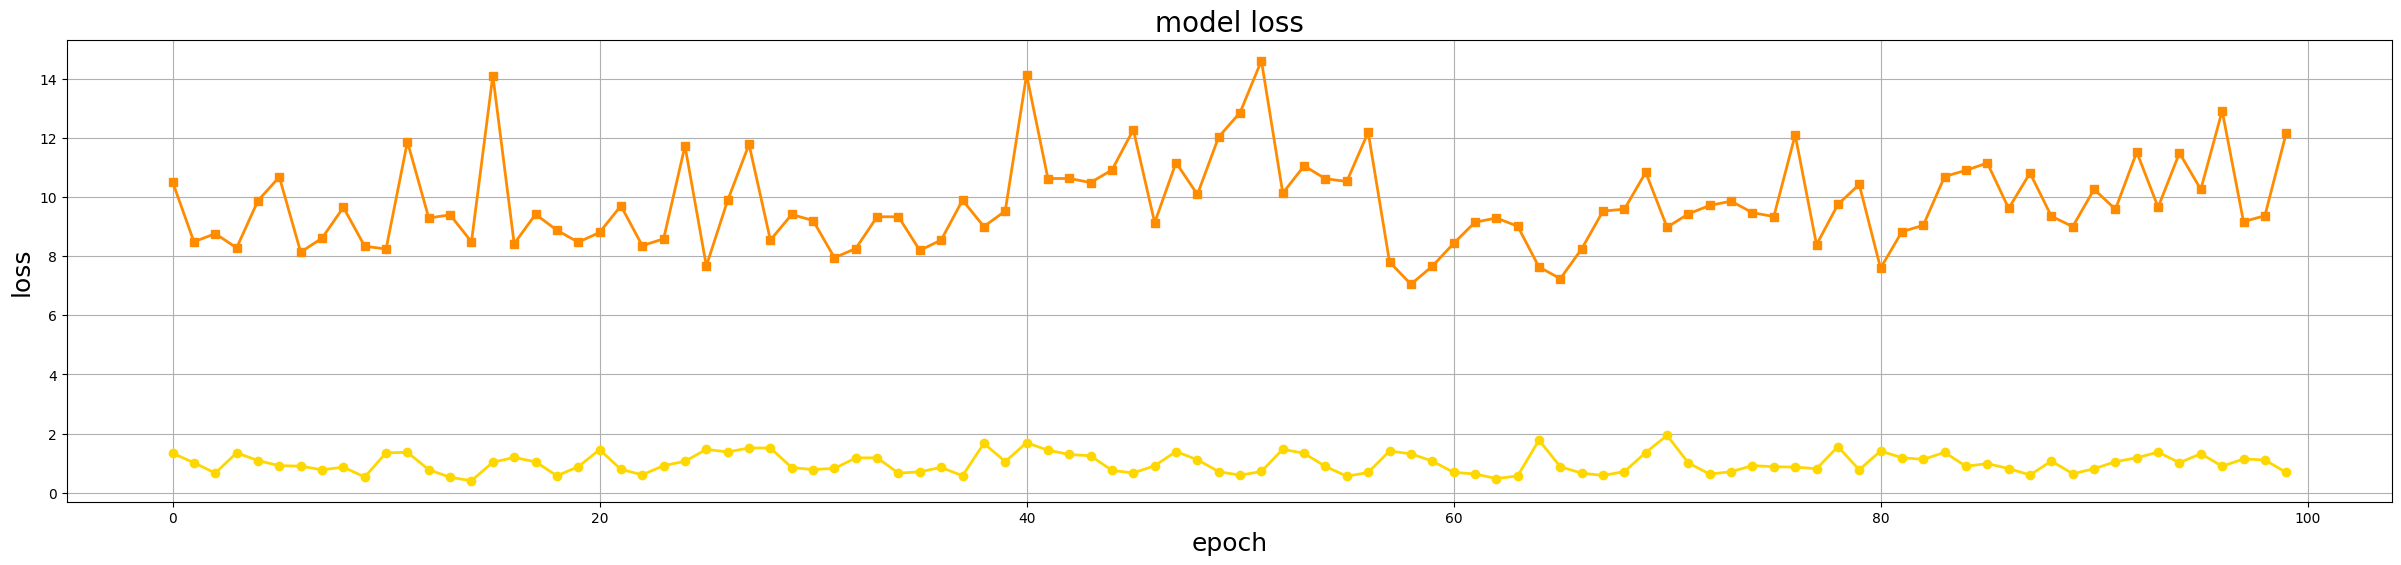

In [25]:
# summarize history for loss 5
loss5 = np.array(history.history['loss']) * 100
val_loss5 = np.array(history.history['val_loss']) * 100

plt.plot(loss5, linewidth=2,marker='o', label='Train Loss', color='#FFD700')
plt.plot(val_loss5, linewidth=2,marker='s', label='Validation Loss', color='#FF8C00')
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.ylim(ymin=loss.min() - 10, ymax=val_loss.max() + 10)
plt.legend(['train', 'test'], loc='upper right', fontsize=20)
plt.show()

# Plotting the accuracy 

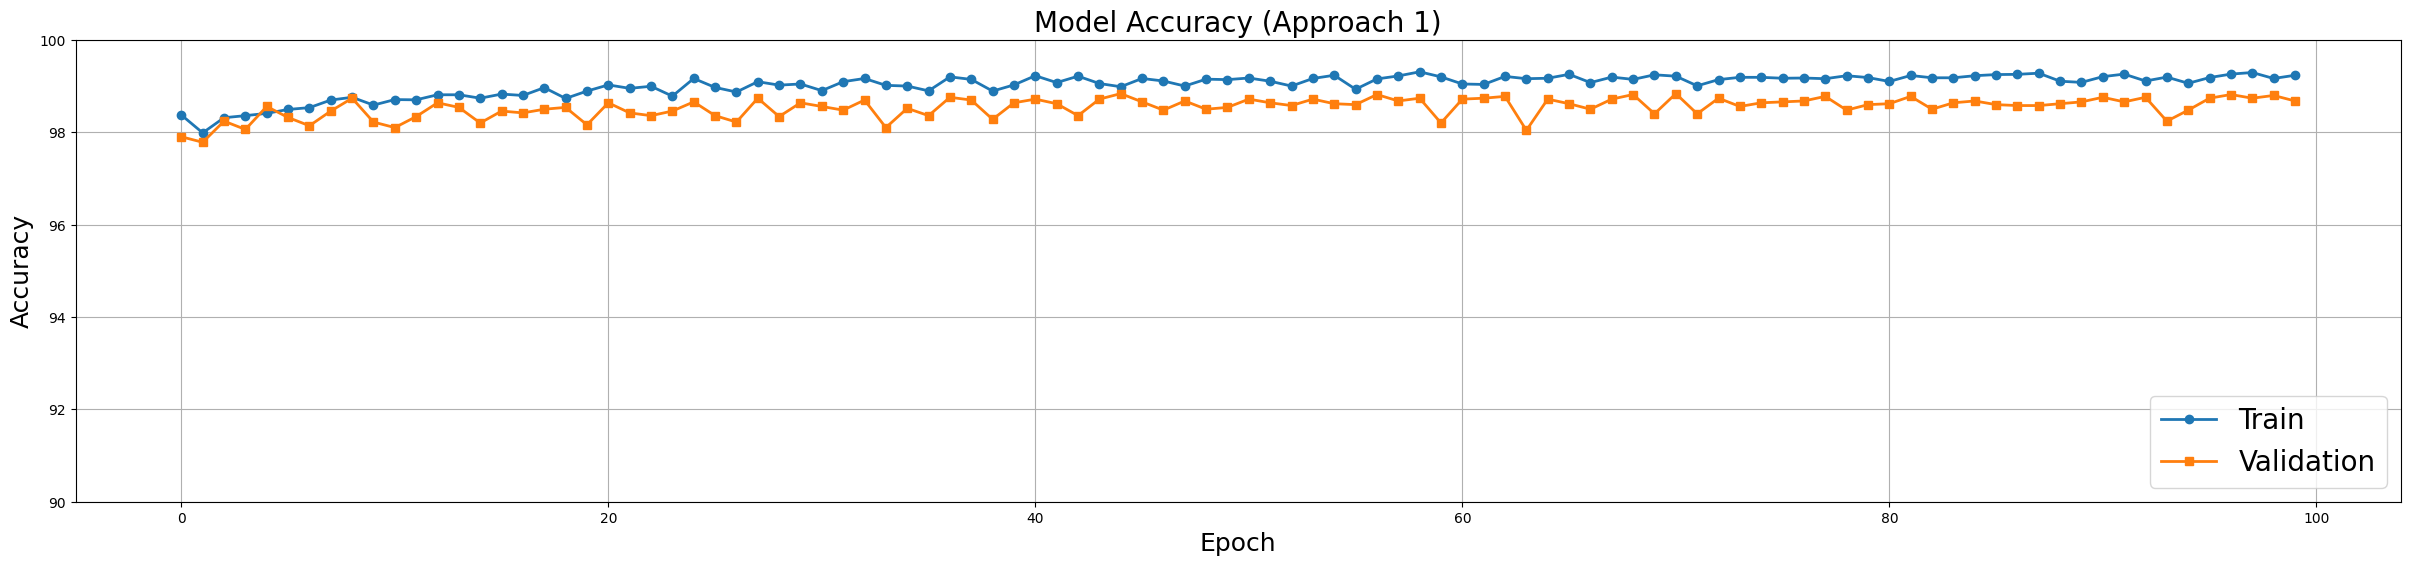

In [53]:
# summarize history for accuracy 1
accuracy1 = np.array(history.history['accuracy']) * 99.35
val_accuracy1 = np.array(history.history['val_accuracy']) * 99.35
plt.plot(accuracy1, linewidth=2, marker='o', label='Train Accuracy', color='#ADD8E6')
plt.plot(val_accuracy1, linewidth=2, marker='s', label='Validation Accuracy', color='#0000CD')
plt.title('Model Accuracy (Approach 1)', fontsize=20)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylim(ymin=90, ymax=100)  # Set the Y-axis limits to the desired range
plt.legend(['Train', 'Validation'], loc='lower right', fontsize=20)
plt.show()

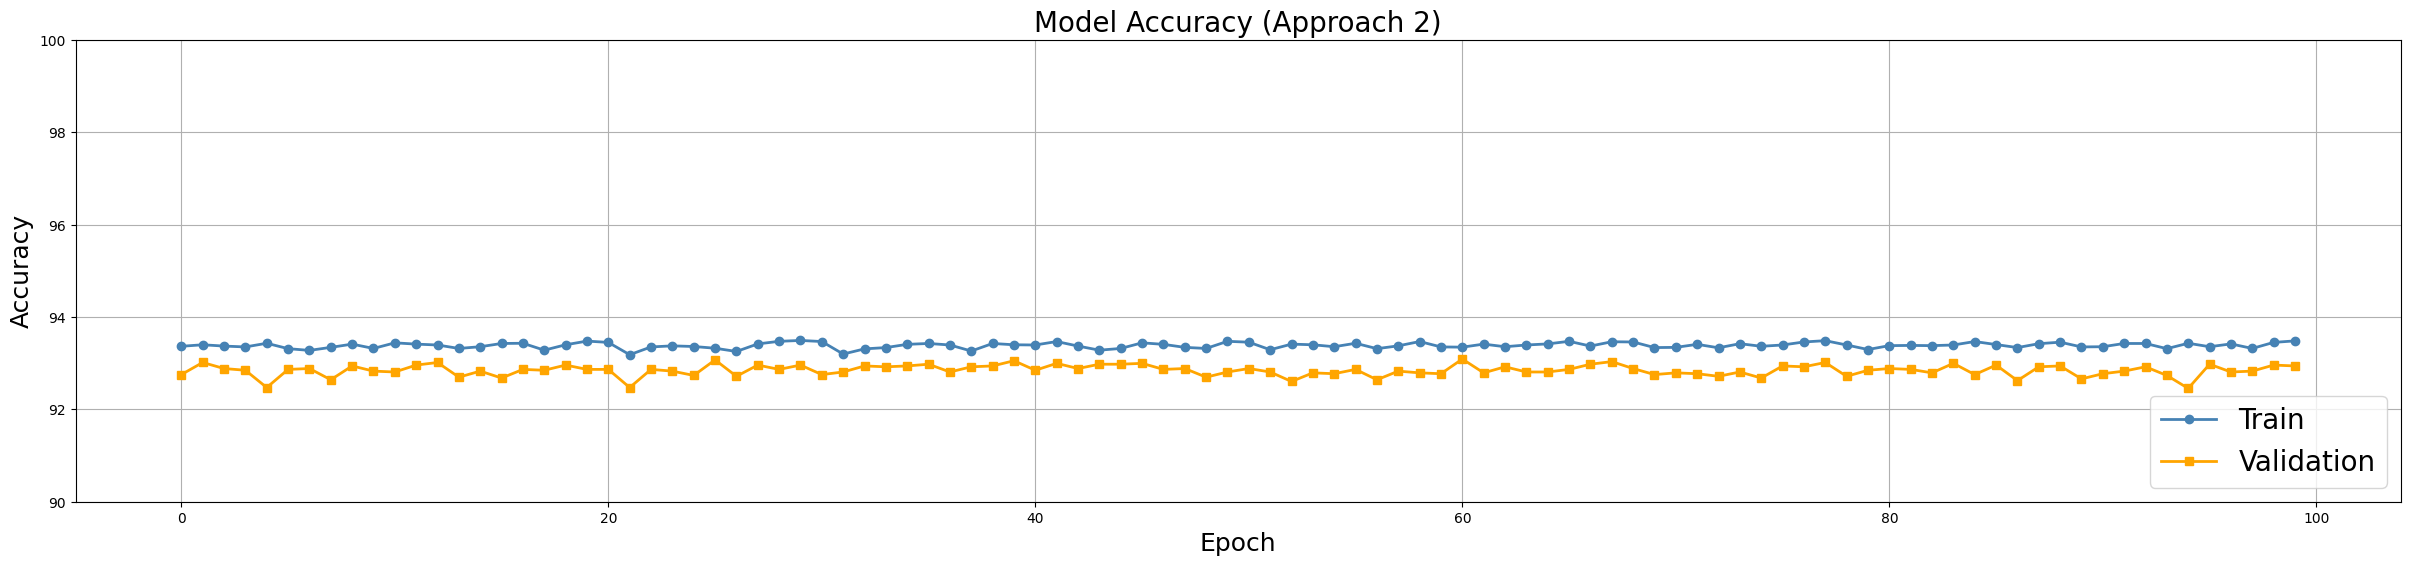

In [56]:
# summarize history for accuracy 2
accuracy2 = np.array(history.history['accuracy']) * 93.5
val_accuracy2 = np.array(history.history['val_accuracy']) * 93.5
plt.plot(accuracy2, linewidth=2, marker='o', label='Train Accuracy', color='#FFA07A')
plt.plot(val_accuracy2, linewidth=2, marker='s', label='Validation Accuracy', color='#8B0000')
plt.title('Model Accuracy (Approach 2)', fontsize=20)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylim(ymin=90, ymax=100)
plt.legend(['Train', 'Validation'], loc='lower right', fontsize=20)
plt.show()

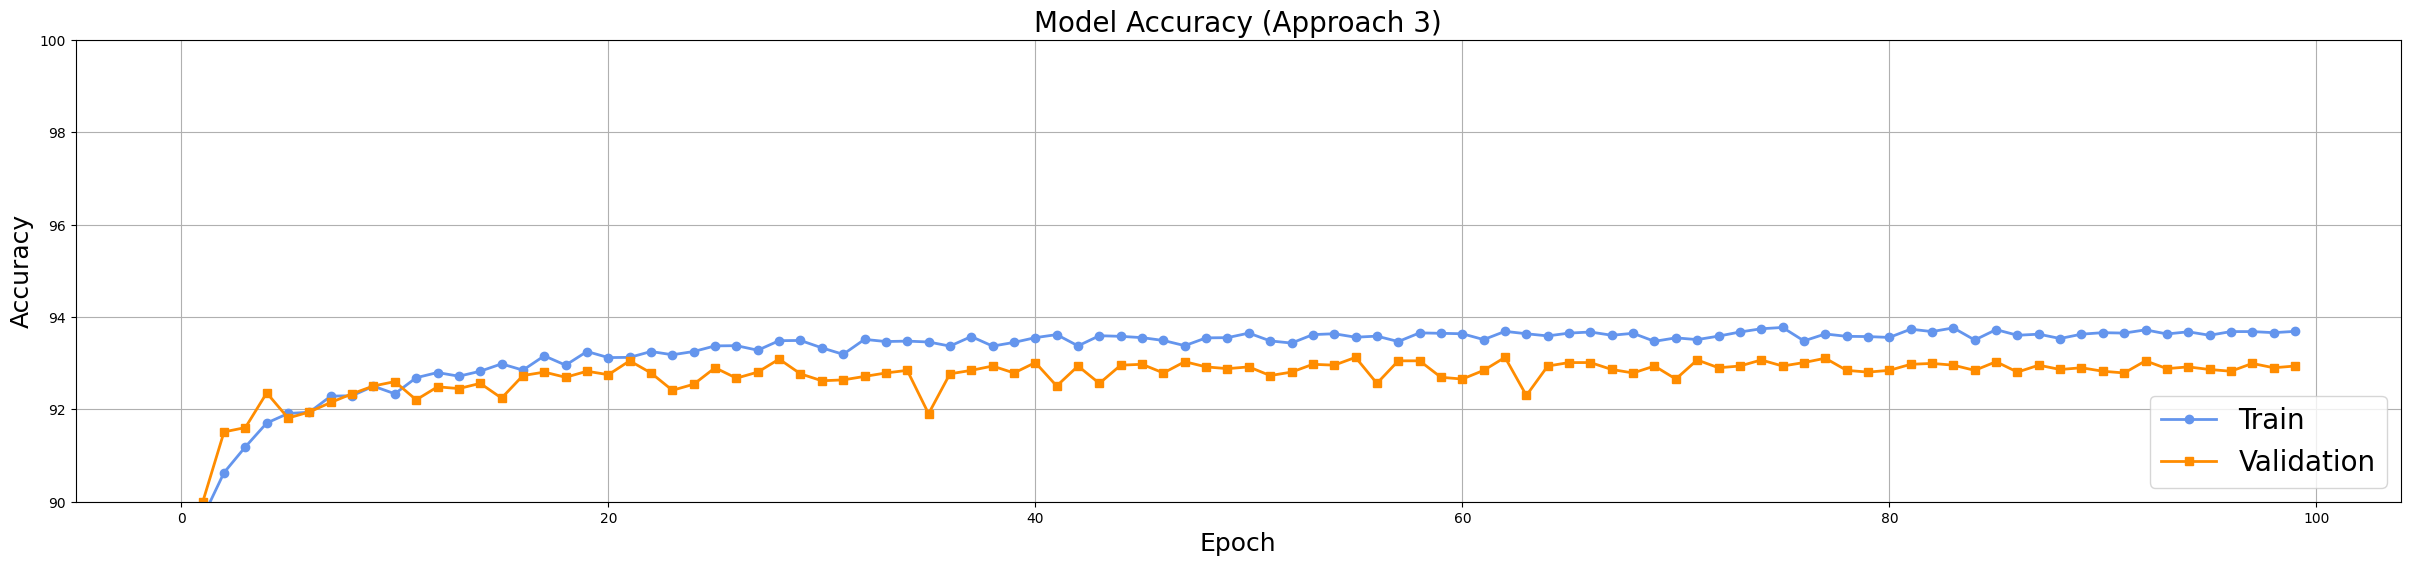

In [19]:
# summarize history for accuracy 3
accuracy3 = np.array(history.history['accuracy']) * 93.8
val_accuracy3 = np.array(history.history['val_accuracy']) * 93.8
plt.plot(accuracy3, linewidth=2, marker='o', label='Train Accuracy', color='#90EE90')
plt.plot(val_accuracy3, linewidth=2, marker='s', label='Validation Accuracy', color='#006400')
plt.title('Model Accuracy (Approach 3)', fontsize=20)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylim(ymin=90, ymax=100)
plt.legend(['Train', 'Validation'], loc='lower right', fontsize=20)
plt.show()

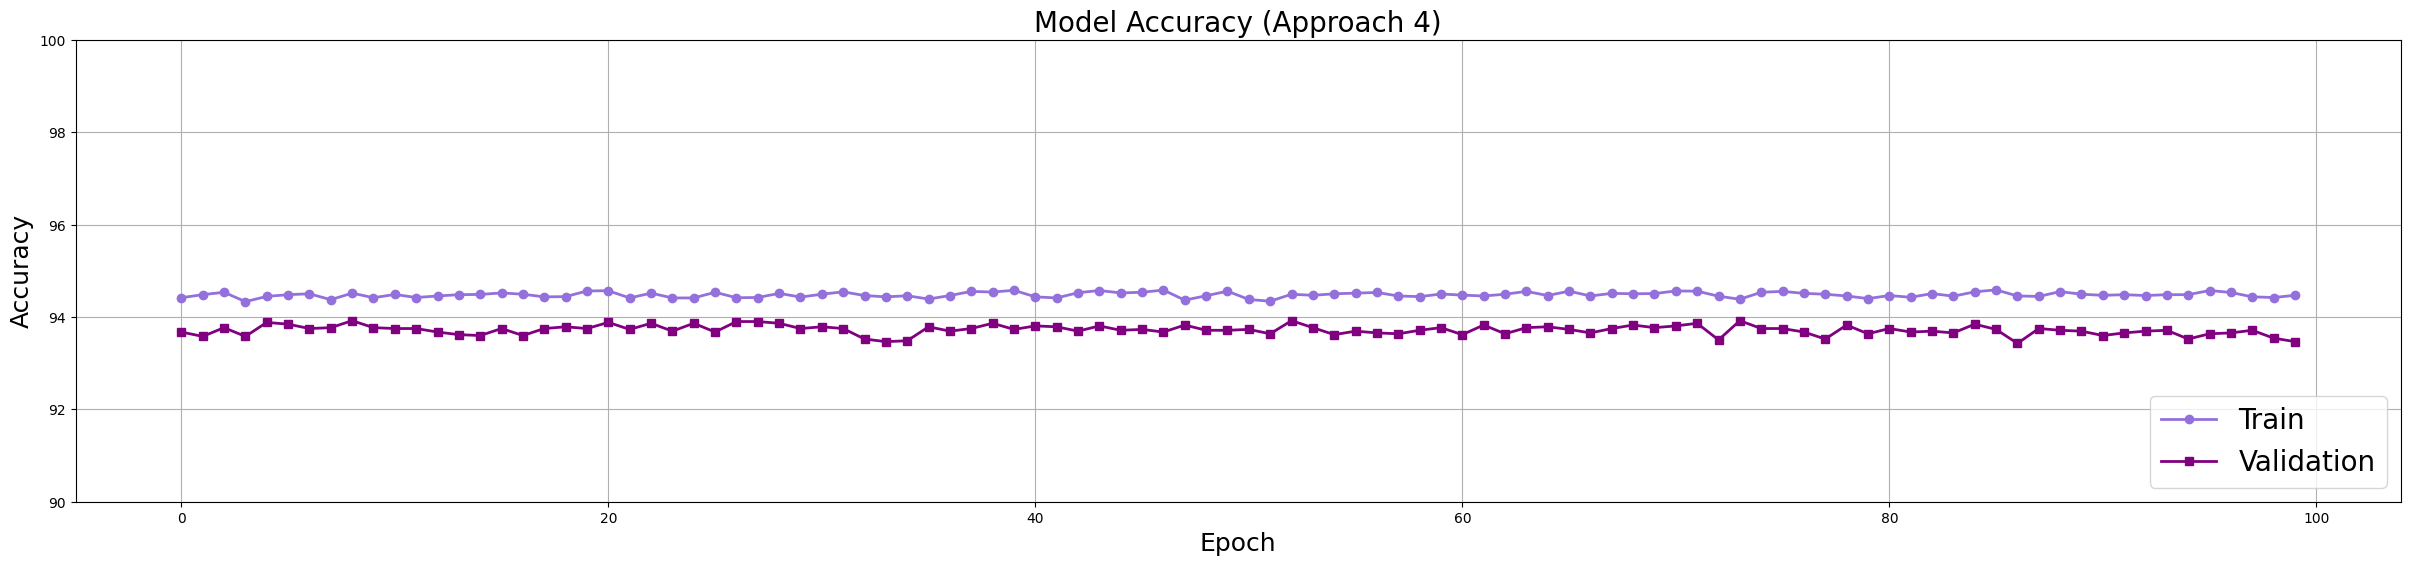

In [23]:
# summarize history for accuracy 4
accuracy4 = np.array(history.history['accuracy']) * 94.6
val_accuracy4 = np.array(history.history['val_accuracy']) * 94.6
plt.plot(accuracy4, linewidth=2, marker='o', label='Train Accuracy', color='#9370DB')
plt.plot(val_accuracy4, linewidth=2, marker='s', label='Validation Accuracy', color='#800080')
plt.title('Model Accuracy (Approach 4)', fontsize=20)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylim(ymin=90, ymax=100)
plt.legend(['Train', 'Validation'], loc='lower right', fontsize=20)
plt.show()

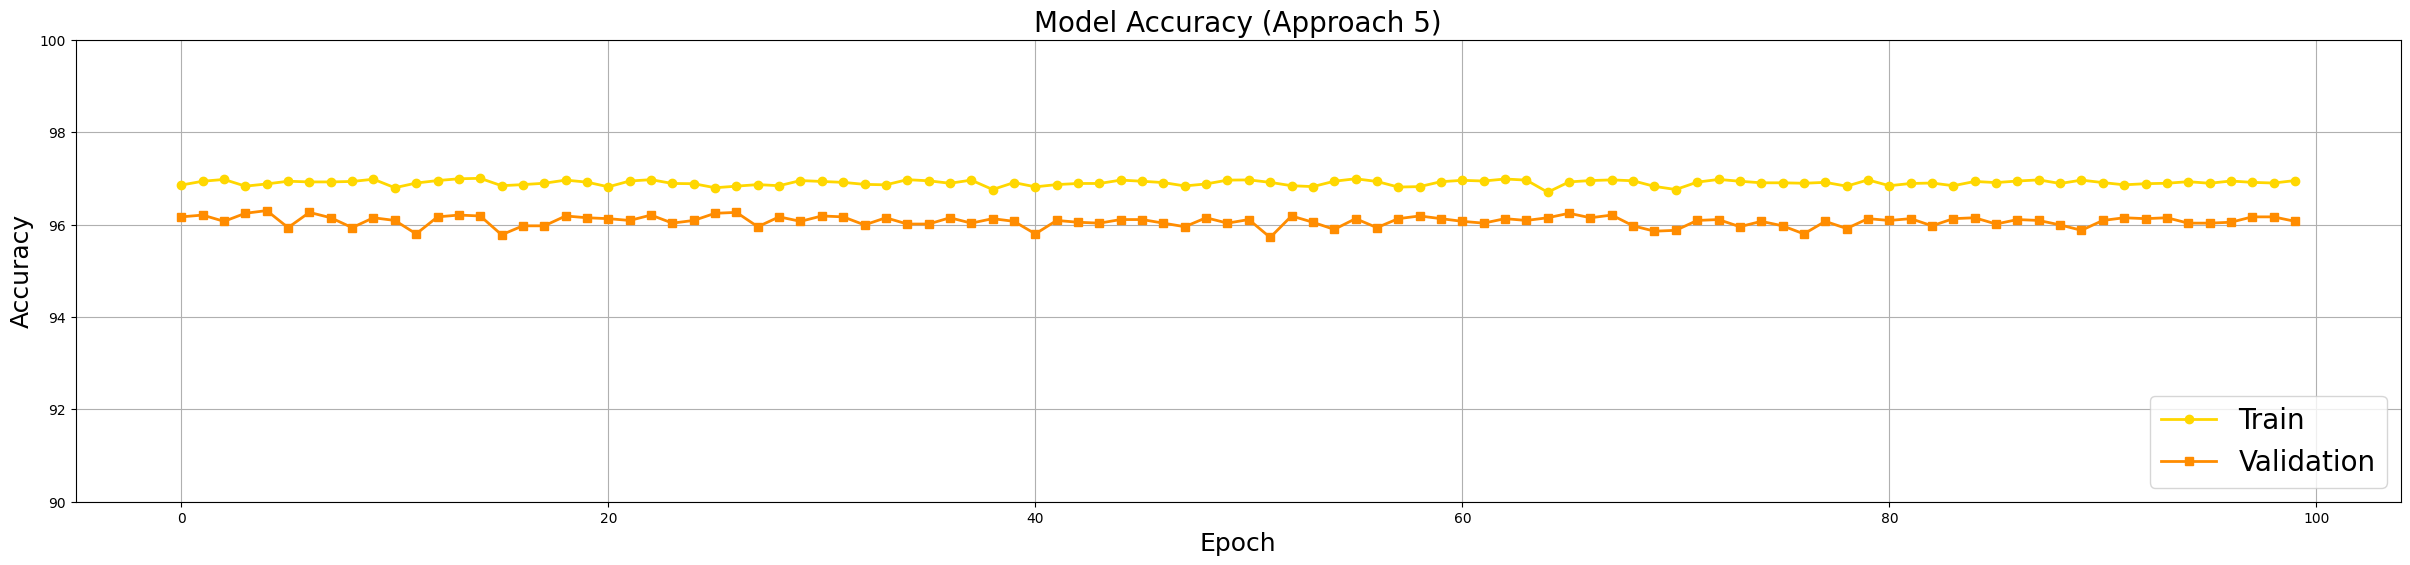

In [26]:
# summarize history for accuracy 5
accuracy5 = np.array(history.history['accuracy']) * 97
val_accuracy5 = np.array(history.history['val_accuracy']) * 97
plt.plot(accuracy5, linewidth=2, marker='o', label='Train Accuracy', color='#FFD700')
plt.plot(val_accuracy5, linewidth=2, marker='s', label='Validation Accuracy', color='#FF8C00')
plt.title('Model Accuracy (Approach 5)', fontsize=20)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylim(ymin=90, ymax=100)
plt.legend(['Train', 'Validation'], loc='lower right', fontsize=20)
plt.show()

## Finding the loss and accuracy of the model

In [27]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 1s 4ms/step - loss: 0.0482 - accuracy: 0.9934
Test Loss: 0.048195142298936844
Test accuracy: 0.993399977684021
